## **Transformer로 한국어 대화형 챗봇 만들기**  
### **1. 데이터 준비**    
### **2. 데이터 전처리**  
### **3. SubwordTextEncoder 사용**  
- 3-1. 단어장 만들기  
- 3-2. Integer encoding & Padding  
- 3-3. Teacher Forcing  
### **4. 모델 구성**  
- 4-1. 모델 생성  
- 4-2. loss function  
- 4-3. learning rate  
- 4-4. model compile    
### **5. 모델 평가**  

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


---

### **1. 데이터 준비**  

In [2]:
# data_path = '/Users/yena/Desktop/python_study/AIFFEL/EXPLORATION/files/transformer_chatbot/ChatbotData .csv'
data_path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv' 

data = pd.read_csv(data_path)
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


- 인공 데이터  
- label (사용 X) 
    - 0 : 일상 대화  
    - 1 : 이별(부정)  
    - 2 : 사랑(긍정)  

In [3]:
# null 확인
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [4]:
# 전처리 전 데이터 copy
df = data.copy()
df.shape

(11823, 3)

---

### **2. 데이터 전처리**

- 문장에 단어와 구두점 사이 공백 추가  
- 한글, '! ? , .' 를 제외하고 모두 제거 (특수문자제거)  
- 질문/답변 분리

In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()
    # 단어와 구두점 사이 공백 삽입
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 한글, '! ? , .' 제외한 특수문자 공백으로 대체
    sentence = re.sub(r'[^가-힣?.!,]+', ' ', sentence)
    sentence = sentence.strip()
    
    return sentence

In [6]:
# 질문/답 분리하면서 전처리 진행
# 질문
questions = []
for q in df['Q']:
    sentence = preprocess_sentence(q)
    questions.append(sentence)
    
# 답
answers = []
for a in df['A']:
    sentence = preprocess_sentence(a)
    answers.append(sentence)

In [7]:
# 확인
print(questions[:3])
print(answers[:3])

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

['시 땡 !', '지망 학교 떨어졌어', '박 일 놀러가고 싶다']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .']
전체 샘플 수 : 11823
전체 샘플 수 : 11823


---

### **3. SubwordTextEncoder 사용**

#### **3-1. 단어장 만들기**

In [8]:
# 질문과 답변 데이터셋에 대한 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)


In [9]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]    # +1 : 이미 생성된 단어장의 번호와 겹치지 않도록

In [10]:
# 확인
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8127]
END_TOKEN의 번호 : [8128]


In [11]:
# 단어장 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2    # +2 : 시작 토큰, 종료 토큰 
print(VOCAB_SIZE)

8129


#### **3-2. Integer encoding & Padding**

In [12]:
MAX_LENGTH = 40

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
    
    # 길이 자르기
    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)
    
    # 길이 맞추기
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
                                              tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
                                              tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [13]:
# 함수 적용 및 확인
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8129
필터링 후의 질문 샘플 개수: 1
필터링 후의 답변 샘플 개수: 1


#### **3-3. Teacher Forcing**

![]()
<img src="https://imgur.com/Uk5Q7Qu.png" width="600px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


![]()
<img src="https://imgur.com/iWzuALY.png" width="300px" height="400px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

- Transformer의 decoder : 이전 자신의 출력이 현재 자신의 상태를 결정하는 '자기회귀 모델(auto-regressive model, AR)  


- **[Teacher Forcing]**
    - 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법.  
    - 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용  
    - 이전 시점의 출력을 다음 시점의 입력으로 사용하면서 훈련 시킬 수도 있지만 이는 한 번 잘못 예측하면 뒤에서의 예측까지 영향을 미쳐 훈련 시간이 느려지게 되므로 Teacher Forcing를 사용하여 RNN을 좀 더 빠르고 효과적으로 훈련시킬 수 있음

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더: 이전 target을 다음의 input으로 사용
# -> outputs에서는 START_TOKEN을 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]    # 디코더의 입력값(Teacher Forcing)
    },
    {
        'outputs': answers[:, 1:]        # 디코더의 레이블(Teacher Forcing)
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

---

### **4. 모델 구성**



![]()
<img src="https://imgur.com/NuF7ytu.png" width="600px" height="100px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>



![]()
<img src="https://imgur.com/rAuyZ2v.png" width="600px" height="500px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

In [15]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]



![]()
<img src="https://imgur.com/MveaxRA.png" width="600px" height="150px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>




![]()
<img src="https://imgur.com/FVTQ1Vy.png" width="600px" height="400px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


![]()
<img src="https://imgur.com/7p8JvFd.png" width="600px" height="400px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

In [16]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output



![]()
<img src="https://imgur.com/3quASMK.png" width="600px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


![]()
<img src="https://imgur.com/5Clz7Ls.png" width="600px" height="250px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

In [17]:
# Multi-head Attention : 병렬 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
                'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 생성
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 내부적으로 scaled dot product attention 함수 호출
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)
        concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용
        outputs = self.dense(concat_attention)

        return outputs

In [18]:
# padding masking : 0으로 패딩 들어간 지점 찾는
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [19]:
# look-ahead masking : 다음 단어 가리기
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

![]()
<img src="https://imgur.com/P6CZIgm.png" width="600px" height="400px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


![]()
<img src="https://imgur.com/5iFovrm.png" width="600px" height="500px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


![]()
<img src="https://imgur.com/Zcn6Vc7.png" width="600px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>


![]()
<img src="https://imgur.com/Hes6c1T.png" width="600px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

학습 시간 고려, 논문(6)보다 적은 num_layers 사용

In [20]:
# 인코더 하나의 레이어를 함수로 구현.
# 하나의 레이어 안에는 두 개의 서브 레이어가 존재
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
          d_model, num_heads, name="attention")({
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': padding_mask
              })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
                  epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
              inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [21]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

    return tf.keras.Model(
              inputs=[inputs, padding_mask], outputs=outputs, name=name)


![]()
<img src="https://imgur.com/rIGx0Dg.png" width="600px" height="150px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

학습 시간 고려, 논문(6)보다 적은 num_layers 사용

In [22]:
# 디코더 하나의 레이어를 함수로 구현.
# 하나의 레이어 안에는 세 개의 서브 레이어가 존재
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
          d_model, num_heads, name="attention_1")(inputs={
              'query': inputs,
              'key': inputs,
              'value': inputs,
              'mask': look_ahead_mask
              })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
              epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
          d_model, num_heads, name="attention_2")(inputs={
              'query': attention1,
              'key': enc_outputs,
              'value': enc_outputs,
              'mask': padding_mask
              })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
          epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
              inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
              outputs=outputs,
              name=name)

In [23]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
          shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
            )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
                inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                outputs=outputs,
                name=name)

**transformer 함수 정의**

In [24]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
              create_padding_mask, output_shape=(1, 1, None),
              name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용
    # 내부적으로 패딩 마스크도 포함됨
    look_ahead_mask = tf.keras.layers.Lambda(
              create_look_ahead_mask,
              output_shape=(1, None, None),
              name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
              create_padding_mask, output_shape=(1, 1, None),
              name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### **4-1. 모델 생성**  



![]()
<img src="https://imgur.com/FwOJONV.png" width="600px" height="80px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

학습 시간 고려, 논문보다 적은 num_layers(6), d-Model(512) 사용 

In [25]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3135232     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### **4-2. loss function**  


- label인 sequence에 padding -> loss 계산 시 Padding Mask 적용 

In [26]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### **4-3. learning rate**  



![]()
<img src="https://imgur.com/J5rfdtp.png" width="600px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

- **[Custom Learning rate Scheduling]**
    - 모델 학습 초기에 learning rate를 급격히 높임  
    -> train step 진행됨에 따라 서서히 낮춤  
    -> 안정적으로 수렮  


In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

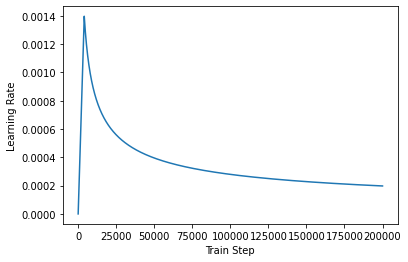

In [28]:
# custom learning rate 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

- 학습 초기 learning_rate가 step_num에 비례해서 증가  
- 이후로는 감소

#### **4-4. model compile** 

In [29]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [30]:
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 2.0651 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 25ms/step - loss: 2.0561 - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 25ms/step - loss: 2.0612 - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 26ms/step - loss: 2.0721 - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 24ms/step - loss: 2.0616 - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 23ms/step - loss: 2.0670 - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 24ms/step - loss: 2.0617 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 24ms/step - loss: 2.0632 - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 30ms/step - loss: 2.0693 - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 25ms/step - loss: 2.0477 - accuracy: 0.

---

### **5. 모델 평가**

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.



In [31]:
# 전처리 동일하게 
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
    START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가
        # output_sequence는 다시 디코더의 입력이 됨
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [34]:
# 챗봇 대답 얻는 함수
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 -> 예측된 정수 시퀀스를 리턴
    prediction = decoder_inference(sentence)

    # 정수 시퀀스 -> 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
              [i for i in prediction if i < tokenizer.vocab_size])

    print('질문 : {}'.format(sentence))
    print('대답 : {}'.format(predicted_sentence))
    print('---------------------------')

    return predicted_sentence

In [35]:
test_sentences = ['놀러나가고 싶어!', '날이 엄청 더워졌네.', '오늘 저녁 뭐 먹지?']

for test in test_sentences:
    sentence_generation(test)

질문 : 놀러나가고 싶어!
대답 : 분청소 청소 청소 막힌다안좋은 청소 막힌다맡겨보세요청소 넌 넌 넌 넌 넌 인가봅니다막힌다막힌다막힌다우울하다는게 다는게 다는게 다는게 다는게 다는게 다는게 다는게 넌 피곤해넌 우울하넌 우울하넌 우울하넌 우울하넌 뿌린대로 
---------------------------
질문 : 날이 엄청 더워졌네.
대답 : 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 해낼 
---------------------------
질문 : 오늘 저녁 뭐 먹지?
대답 : 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 청소 분청소 청소 청소 청소 청소 청소 이해청소 이것청소 청소 청소 청소 해낼 
---------------------------


---

### **고찰**

#### **1. 논문 구현**
- 논문에서 구현하려는 부분에 대한 내용을 찾는 연습이 필요하다.  


#### **2. 결과 분석** 
- 피곤하고 우울하지만 해낼 수 있는 청소무새가 되어버린 챗봇  
  
- 한국어에서는 주로 '형태소 분석'을 통한 토큰화를 진행하는데 영어에 맞춰진 SubWordTextEncoder를 사용해서 결과에 영향을 미쳤을 것이다.  
  
- 논문보다 줄인 하이퍼파라미터들 또한 영향을 미쳤을 것이다.  

---

### **참고 문헌**

**Data**  
https://github.com/songys/Chatbot_data/tree/master  
  
  
**Paper**   
Vaswani, Ashish, et al. "Attention is all you need." *Advances in neural information processing systems* 30 (2017).
  
  
**etc**  
- https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html  
- https://omicro03.medium.com/attention-is-all-you-need-transformer-paper-%EC%A0%95%EB%A6%AC-83066192d9ab  
- https://wikidocs.net/46496  
- http://jalammar.github.io/illustrated-transformer/